In [1]:
#!pip install sdv
#!pip install ctgan

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

import sys
import numpy as np
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Activation, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import pandas as pd
import os
import sqlite3

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)

In [3]:
import sys
IN_COLAB = 'google.colab' in sys.modules

path_prefix = ''

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    #path_prefix = '/content/drive/My Drive/eICU_gan/eICU_gan_data.db'
    path_prefix = '/content/drive/My Drive/eICU_gan/'

else:
    path_prefix = '../data/'

In [4]:
conn_eICU = sqlite3.connect(path_prefix + 'eICU_gan_data.db')

In [5]:
'''sql = """SELECT * FROM patient"""
data_patients = pd.read_sql(sql, conn_eICU)
data_patients.head()'''

'sql = """SELECT * FROM patient"""\ndata_patients = pd.read_sql(sql, conn_eICU)\ndata_patients.head()'

# Try with age unit type

In [6]:
npy_age_unittype = np.load(path_prefix + 'eICU_age_unittype.npy', allow_pickle=True)
df_ages = pd.DataFrame(zip(np.asarray(npy_age_unittype[:,0].flatten().tolist()).flatten(), np.asarray(npy_age_unittype[:,1].flatten().tolist()).flatten()), columns=['age','unit'])

In [7]:
df_ages.head()

,age,unit
0,59,CTICU
1,55,CTICU
2,72,Cardiac ICU
3,49,CTICU
4,49,CTICU


In [8]:
import sys
sys.path.insert(0,'..')

from dataprep import create_eICU_data
os.getcwd()

'c:\\Users\\dianam\\Documents\\jlab_datascience\\PlayGround\\DS6050\\eICU_gan\\gan_work'

In [9]:
# create data set without 90 or greater since that was a category flattened
df_ages_filtered = df_ages.query("age < 90")

df_original_ages_filtered = df_ages.query("age < 90")

df_ages_filtered = create_eICU_data.minmax_scale_columns(df_ages_filtered, ['age'])
print(df_ages_filtered.head())

all_ages = df_ages_filtered['age'].values
all_labels = df_ages_filtered['unit'].values

# Create tf.data.Dataset: suffle, batch, prefetch
dataset = tf.data.Dataset.from_tensor_slices((all_ages, all_labels))
dataset = dataset.shuffle(buffer_size=200).batch(64).prefetch(1)


        age         unit
0  0.558824        CTICU
1  0.500000        CTICU
2  0.750000  Cardiac ICU
3  0.411765        CTICU
4  0.411765        CTICU


In [10]:
from ctgan import CTGANSynthesizer

In [11]:
df_ages_filtered[['age', 'unit']][0:5]

,age,unit
0,0.558824,CTICU
1,0.500000,CTICU
2,0.750000,Cardiac ICU
3,0.411765,CTICU
4,0.411765,CTICU


In [12]:
from sdv.tabular import CTGAN

In [13]:
ctgan = CTGAN(verbose=True, epochs = 2000, batch_size = 40)
ctgan.fit(df_ages_filtered[['age', 'unit']])

C:\Users\dianam\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
C:\Users\dianam\AppData\Local\Programs\Python\Python39\lib\site-packages\ctgan\data_transformer.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column_name] = data[column_name].to_numpy().flatten()


Epoch 1, Loss G:  0.9796,Loss D: -0.0768
Epoch 2, Loss G:  0.9394,Loss D: -0.0350
Epoch 3, Loss G:  1.0653,Loss D: -0.0567
Epoch 4, Loss G:  1.0437,Loss D: -0.0869
Epoch 5, Loss G:  1.0680,Loss D: -0.0654
Epoch 6, Loss G:  1.0077,Loss D:  0.0267
Epoch 7, Loss G:  0.8503,Loss D:  0.1060
Epoch 8, Loss G:  0.9032,Loss D:  0.2711
Epoch 9, Loss G:  0.9905,Loss D:  0.2729
Epoch 10, Loss G:  0.6427,Loss D: -0.0779
Epoch 11, Loss G:  0.8055,Loss D:  0.1069
Epoch 12, Loss G:  0.6197,Loss D: -0.2559
Epoch 13, Loss G:  0.5523,Loss D: -0.1177
Epoch 14, Loss G:  0.8168,Loss D: -0.0082
Epoch 15, Loss G:  0.9141,Loss D: -0.0030
Epoch 16, Loss G:  0.8007,Loss D:  0.4257
Epoch 17, Loss G:  0.6061,Loss D:  0.3583
Epoch 18, Loss G:  0.9583,Loss D:  0.2782
Epoch 19, Loss G:  0.7469,Loss D:  0.1281
Epoch 20, Loss G:  0.2449,Loss D:  0.5270
Epoch 21, Loss G:  0.7014,Loss D:  0.0047
Epoch 22, Loss G:  0.6711,Loss D:  0.0328
Epoch 23, Loss G:  0.4354,Loss D: -0.0628
Epoch 24, Loss G:  0.8520,Loss D: -0.3399
E

In [14]:
samples = ctgan.sample(df_ages_filtered.shape[0])
samples['data'] = 'GAN'
df_ages_filtered['data'] = 'Real'
both = pd.concat([samples, df_ages_filtered[['age', 'unit', 'data']]])

csICU = both[both['unit'] == 'CSICU'].reset_index().drop('index', axis = 1)
ctICU = both[both['unit'] == 'CTICU'].reset_index().drop('index', axis = 1)
cardiacICU = both[both['unit'] == 'Cardiac ICU'].reset_index().drop('index', axis = 1)

<function matplotlib.pyplot.show(close=None, block=None)>

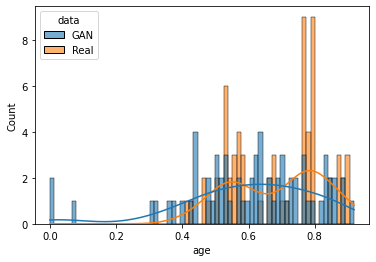

In [21]:
sns.histplot(data = csICU, x='age', hue='data', bins=70, color='orange', kde=True, alpha=0.6)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

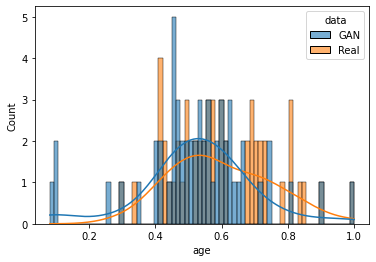

In [22]:
sns.histplot(data = ctICU, x='age', hue='data', bins=70, color='orange', kde=True, alpha=0.6)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

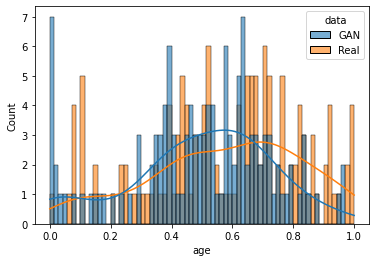

In [23]:
sns.histplot(data = cardiacICU, x='age', hue='data', bins=70, color='orange', kde=True, alpha=0.6)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

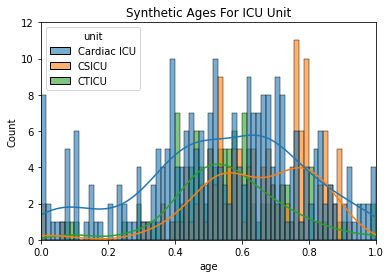

In [24]:
sns.histplot(data=both, x='age', hue='unit', bins=70, kde=True, alpha=0.6)
plt.xlim(0,1)
plt.ylim(0,12)
plt.title('Synthetic Ages For ICU Unit')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

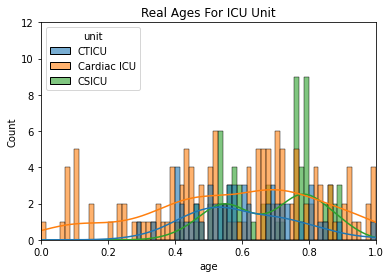

In [25]:
sns.histplot(data=df_ages_filtered, x='age', hue='unit', bins=70, kde=True, alpha=0.6)
plt.xlim(0,1)
plt.ylim(0,12)
plt.title('Real Ages For ICU Unit')
plt.show

In [26]:
# need to inverse scale the sythetic CTGAN data
from dataprep import create_eICU_data as eICU_dataprep
df_ctgan_ages = eICU_dataprep.minmax_inversescale_columns(samples, df_original_ages_filtered, ['age'])

In [27]:
df_ctgan_ages.head()

,age,unit,data
0,40.806715,Cardiac ICU,GAN
1,47.404645,Cardiac ICU,GAN
2,70.361061,CSICU,GAN
3,86.066472,Cardiac ICU,GAN
4,58.484607,CTICU,GAN


<function matplotlib.pyplot.show(close=None, block=None)>

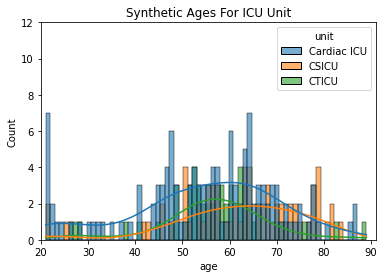

In [31]:
sns.histplot(data=df_ctgan_ages, x='age', hue='unit', bins=70, kde=True, alpha=0.6)
plt.xlim(20,91)
plt.ylim(0,12)
plt.title('Synthetic Ages For ICU Unit')
plt.show

In [32]:
df_ctgan_ages.to_csv(path_prefix + 'CTGAN_age_unittype.csv', index=False)

# Redo with age ethnicity

In [34]:
npy_age_eth = np.load(path_prefix + 'eICU_age_ethnicity.npy', allow_pickle=True)
df_ages_eths = pd.DataFrame(zip(np.asarray(npy_age_eth[:,0].flatten().tolist()).flatten(), np.asarray(npy_age_eth[:,1].flatten().tolist()).flatten()), columns=['age','ethnicity'])

# create data set without 90 or greater since that was a category flattened
df_ages_eths_filtered = df_ages_eths.query("age < 90")

df_original_ages_eths_filtered = df_ages_eths.query("age < 90")

df_ages_eths_filtered = create_eICU_data.minmax_scale_columns(df_ages_eths_filtered, ['age'])
print(df_ages_eths_filtered.head())

all_ages_foreths = df_ages_eths_filtered['age'].values
all_labels_foreths = df_ages_eths_filtered['ethnicity'].values

# Create tf.data.Dataset: suffle, batch, prefetch
dataset_ages_eths = tf.data.Dataset.from_tensor_slices((all_ages, all_labels))
dataset_ages_eths  = dataset.shuffle(buffer_size=200).batch(64).prefetch(1)


df_ages_eths_filtered.head()

        age  ethnicity
0  0.972973  Caucasian
1  0.972973  Caucasian
2  0.824324  Caucasian
3  0.256757  Caucasian
4  0.621622  Caucasian


c:\Users\dianam\Documents\jlab_datascience\PlayGround\DS6050\eICU_gan\gan_work\..\dataprep\create_eICU_data.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = [(x - col_min)/(col_max - col_min) for x in df[column]]


,age,ethnicity
0,0.972973,Caucasian
1,0.972973,Caucasian
2,0.824324,Caucasian
3,0.256757,Caucasian
4,0.621622,Caucasian


In [35]:
ctgan_eths = CTGAN(verbose=True, epochs = 2000, batch_size = 40)
ctgan_eths.fit(df_ages_eths_filtered[['age', 'ethnicity']])

C:\Users\dianam\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
C:\Users\dianam\AppData\Local\Programs\Python\Python39\lib\site-packages\ctgan\data_transformer.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column_name] = data[column_name].to_numpy().flatten()


Epoch 1, Loss G:  0.9964,Loss D: -0.0752
Epoch 2, Loss G:  0.7497,Loss D:  0.3309
Epoch 3, Loss G:  0.7017,Loss D: -0.0972
Epoch 4, Loss G:  0.5886,Loss D: -0.0613
Epoch 5, Loss G:  0.7159,Loss D: -0.0583
Epoch 6, Loss G:  0.6988,Loss D: -0.2493
Epoch 7, Loss G:  0.3319,Loss D: -0.1217
Epoch 8, Loss G:  0.2834,Loss D:  0.5786
Epoch 9, Loss G:  0.1374,Loss D:  0.1543
Epoch 10, Loss G: -0.1148,Loss D: -0.1985
Epoch 11, Loss G: -0.0069,Loss D: -0.2328
Epoch 12, Loss G:  0.0452,Loss D: -0.2241
Epoch 13, Loss G:  0.2038,Loss D:  0.5269
Epoch 14, Loss G:  0.4469,Loss D: -0.2329
Epoch 15, Loss G:  0.0087,Loss D: -0.3303
Epoch 16, Loss G: -0.2142,Loss D:  0.3124
Epoch 17, Loss G:  0.0331,Loss D: -0.2117
Epoch 18, Loss G: -0.1812,Loss D: -0.0231
Epoch 19, Loss G: -0.3954,Loss D: -0.1332
Epoch 20, Loss G: -0.0923,Loss D:  0.5069
Epoch 21, Loss G: -0.0284,Loss D: -0.3405
Epoch 22, Loss G: -0.1776,Loss D: -0.2206
Epoch 23, Loss G: -0.3885,Loss D: -0.0208
Epoch 24, Loss G: -0.1041,Loss D: -0.2936
E

In [45]:
samples_eths = ctgan.sample(df_ages_eths_filtered.shape[0])
samples_eths['data'] = 'GAN'
df_ages_eths_filtered['data'] = 'Real'
both = pd.concat([samples_eths, df_ages_eths_filtered[['age', 'ethnicity', 'data']]])
both.head()
#caucasian = both[both['ethnicity'] == 'Caucasian'].reset_index().drop('index', axis = 1)
#hispanic = both[both['ethnicity'] == 'Hispanic'].reset_index().drop('index', axis = 1)
#asian = both[both['ethnicity'] == 'Asian'].reset_index().drop('index', axis = 1)
#other = both[both['ethnicity'] == 'Other\Unknown'].reset_index().drop('index', axis = 1)
#native = both[both['ethnicity'] == 'Native American'].reset_index().drop('index', axis = 1)

<ipython-input-45-4be059655024>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ages_eths_filtered['data'] = 'Real'


,age,unit,data,ethnicity
0,0.578616,Cardiac ICU,GAN,NaN
1,0.531607,CTICU,GAN,NaN
2,0.373752,CSICU,GAN,NaN
3,0.517217,Cardiac ICU,GAN,NaN
4,0.734299,CSICU,GAN,NaN


In [38]:
df_ctgan_ages_eths = eICU_dataprep.minmax_inversescale_columns(samples_eths, df_original_ages_eths_filtered, ['age'])

In [44]:
df_ctgan_ages_eths.head()

,age,unit,data
0,20.514129,Cardiac ICU,GAN
1,50.635432,CSICU,GAN
2,52.146001,Cardiac ICU,GAN
3,67.046049,Cardiac ICU,GAN
4,61.939673,Cardiac ICU,GAN


In [43]:
sns.histplot(data=df_ctgan_ages_eths, x='age', hue='ethnicity', bins=70, kde=True, alpha=0.6)
plt.xlim(20,91)
plt.ylim(0,12)
plt.title('Synthetic Ages For ICU Unit')
plt.show

ValueError: Could not interpret value `ethnicity` for parameter `hue`

<function matplotlib.pyplot.show(close=None, block=None)>

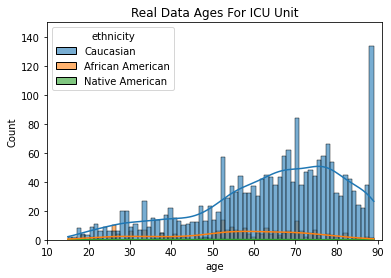

In [42]:
sns.histplot(data=df_original_ages_eths_filtered, x='age', hue='ethnicity', bins=70, kde=True, alpha=0.6)
plt.xlim(10,91)
plt.ylim(0,150)
plt.title('Real Data Ages For ICU Unit')
plt.show

In [ ]:
df_ctgan_ages_eths.to_csv(path_prefix + 'CTGAN_age_ethnicity.csv', index=False)